In [3]:
# !conda install seaborn==0.9.0 --yes
!pip install hdbscan

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
sns.__version__

'0.9.0'

In [5]:
DROP_OUTLIERS = True
LOG_TRANSFORM = True

# Read Csv

In [6]:
datetime_cols = ['status_published']

raw_df = pd.read_csv('Live.csv', parse_dates=datetime_cols)
raw_df.head()

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,246675545449582_1649696485147474,video,2018-04-22 06:00:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,246675545449582_1649426988507757,photo,2018-04-21 22:45:00,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,246675545449582_1648730588577397,video,2018-04-21 06:17:00,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,246675545449582_1648576705259452,photo,2018-04-21 02:29:00,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,246675545449582_1645700502213739,photo,2018-04-18 03:22:00,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


In [7]:
raw_df.columns

Index(['status_id', 'status_type', 'status_published', 'num_reactions',
       'num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows',
       'num_hahas', 'num_sads', 'num_angrys', 'Column1', 'Column2', 'Column3',
       'Column4'],
      dtype='object')

In [8]:
cat_cols = ['status_type']
numerical_cols = ['num_reactions', 'num_comments',
                  'num_shares', 'num_likes',
                  'num_loves', 'num_wows',
                  'num_hahas', 'num_sads',
                  'num_angrys']
other_cols = ['status_id']

# Cloning For Data Transformation

In [9]:
df = raw_df.copy()

# Add Year, Month, Day, DayofWeek Cols to Each Datetime Col
and numerical_cols += [ Y, M, D, h ] x N

In [10]:
for col in datetime_cols:
    df[col + '_year'] = df[col].map(lambda ts: ts.year)
    df[col + '_month'] = df[col].map(lambda ts: ts.month)
    df[col + '_day'] = df[col].map(lambda ts: ts.day)
    df[col + '_dayofweek'] = df[col].map(lambda ts: ts.dayofweek)
    df[col + '_hour'] = df[col].map(lambda ts: ts.hour)

    numerical_cols += [
        col + '_year',
        col + '_month',
        col + '_day',
        col + '_dayofweek',
        col + '_hour',
    ]

# General Outlook

In [11]:
df.shape

(7050, 21)

In [12]:
import math

def feature_distribution_plots(cols, df, categorical=False):    
    ncols = min(len(cols), 3)
    nrows = math.ceil(len(cols) / ncols)

    f, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3.7))
            
    for i, col in enumerate(df[cols].columns):
        if ncols == 1 and nrows == 1:
            ax = axes
        elif ncols == 1 or nrows == 1:
            ax = axes[i]
        else:
            ax = axes[int(i / ncols), i % ncols]
        
        if categorical:
            sns.countplot(df[col], ax=ax);
        else:
            sns.distplot(df[col].dropna(), ax=ax)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


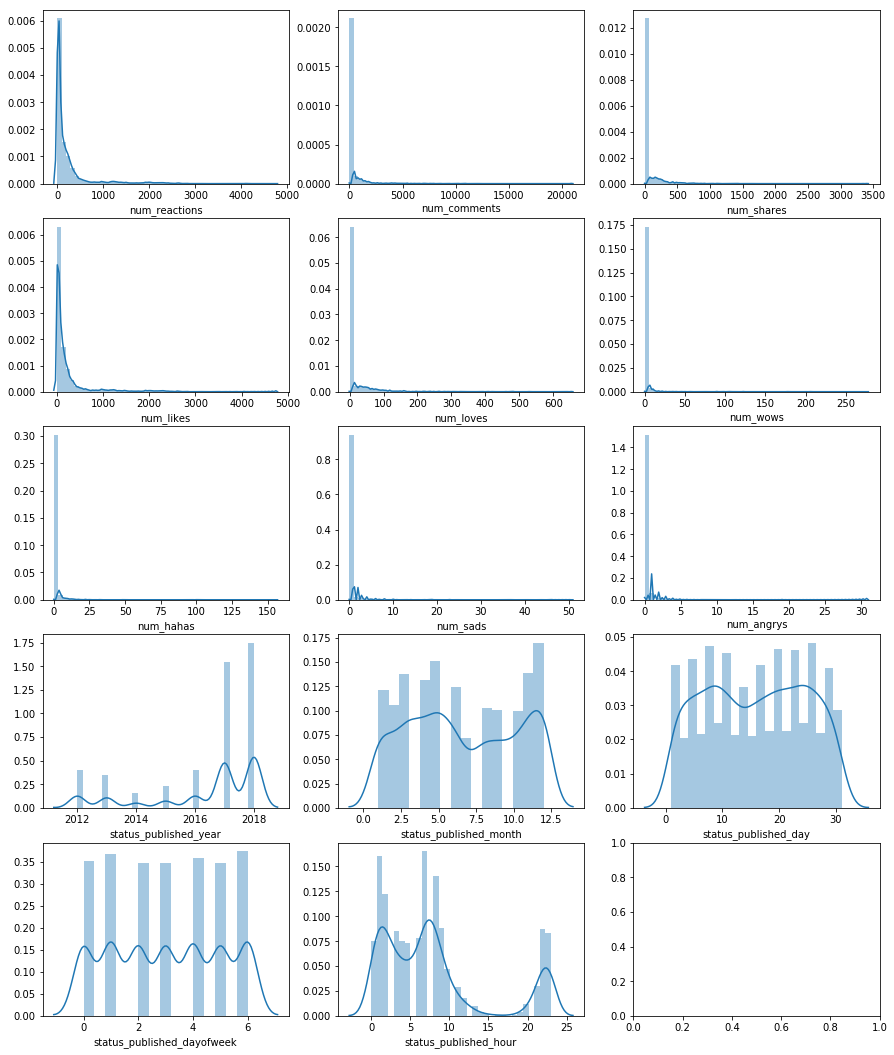

In [13]:
# Numerical kdeplots
feature_distribution_plots(numerical_cols, df)

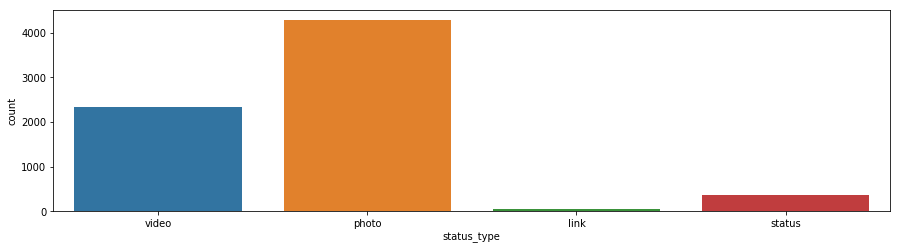

In [14]:
feature_distribution_plots(cat_cols, df, categorical=True)

In [15]:
df.skew()

status_id                      2.301498
num_reactions                  3.738452
num_comments                   9.028850
num_shares                     7.099332
num_likes                      3.919128
num_loves                      6.004845
num_wows                      18.246813
num_hahas                     20.305741
num_sads                      17.578868
num_angrys                    19.507129
Column1                             NaN
Column2                             NaN
Column3                             NaN
Column4                             NaN
status_published_year         -1.192322
status_published_month         0.068264
status_published_day          -0.015204
status_published_dayofweek     0.000414
status_published_hour          1.129664
dtype: float64

# Picking (And Remove) Outliers (Possible Clusters)

Using Z score = ( Observation — Mean ) / Standard Deviation

In [16]:
from scipy import stats

def pick_outliers(remove_inplace=False):
    threshold = 3
    outliers = {}

    # Remove outliers (inplace)
    for col in numerical_cols:
        zscores = np.abs(stats.zscore(df[col]))
        outlier_indices = df[col][zscores >= threshold].index
        outliers[col] = outlier_indices

        if remove_inplace:
            df.drop(outlier_indices, inplace=True)

    # Print outliers count
    for key in outliers.keys():
        print(key + ' ' + str(len(outliers[key])))
        
    return outliers
        
outliers = pick_outliers(remove_inplace=DROP_OUTLIERS)

num_reactions 235
num_comments 126
num_shares 161
num_likes 210
num_loves 195
num_wows 141
num_hahas 64
num_sads 42
num_angrys 33
status_published_year 0
status_published_month 0
status_published_day 0
status_published_dayofweek 0
status_published_hour 0


# Log-Transform if skewness > 1

In [17]:
# plt.xlabel('original value')
# plt.ylabel('transformed value')
# sns.lineplot(x=range(1, 10000), y=np.log1p(range(1, 10000)))

In [18]:
skewness = df[[col for col in df.columns if col not in other_cols]].skew() 

In [19]:
skewness[skewness.abs() > 1].index # if [-1, 1] => normally distributed

Index(['num_reactions', 'num_comments', 'num_shares', 'num_likes', 'num_loves',
       'num_wows', 'num_hahas', 'num_sads', 'num_angrys',
       'status_published_year', 'status_published_hour'],
      dtype='object')

In [20]:
if LOG_TRANSFORM:
    for col in skewness[skewness.abs() > 1].index:
        df[col] = df[col].map(np.log1p)

In [21]:
df.skew()

status_id                     2.436327
num_reactions                -0.267282
num_comments                  1.257311
num_shares                    2.046935
num_likes                    -0.270338
num_loves                     1.831486
num_wows                      2.180165
num_hahas                     3.569752
num_sads                      5.759769
num_angrys                    7.082593
Column1                            NaN
Column2                            NaN
Column3                            NaN
Column4                            NaN
status_published_year        -1.134387
status_published_month        0.039998
status_published_day         -0.008777
status_published_dayofweek    0.011538
status_published_hour        -0.328824
dtype: float64

In [22]:
# feature_distribution_plots(cols=numerical_cols, df=df)

# Missing Data Ratio Of Each Col

status_id                     0.0
status_type                   0.0
status_published              0.0
num_reactions                 0.0
num_comments                  0.0
num_shares                    0.0
num_likes                     0.0
num_loves                     0.0
num_wows                      0.0
num_hahas                     0.0
num_sads                      0.0
num_angrys                    0.0
Column1                       1.0
Column2                       1.0
Column3                       1.0
Column4                       1.0
status_published_year         0.0
status_published_month        0.0
status_published_day          0.0
status_published_dayofweek    0.0
status_published_hour         0.0
dtype: float64


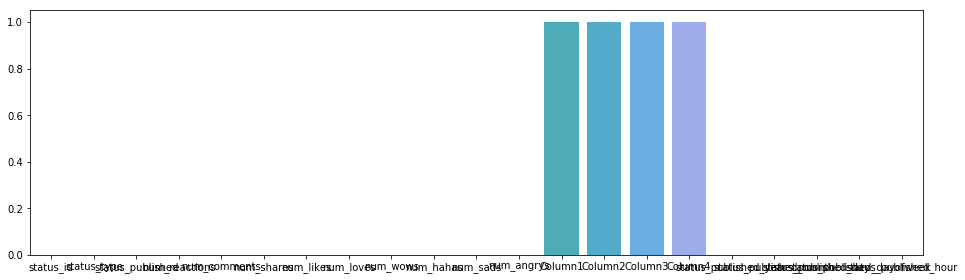

In [23]:
missing_ratios = df.isnull().sum() / len(df)
plt.figure(figsize=(16, 4.5))
sns.barplot(x=missing_ratios.index, y=missing_ratios.values)
print(missing_ratios)

In [24]:
# TODO: interpolate missing values

In [25]:
threshold = 0.5
df.drop(columns=missing_ratios[missing_ratios > threshold].index, inplace=True)

# Checking Data Type Of Each Col

In [26]:
df.dtypes

status_id                             object
status_type                           object
status_published              datetime64[ns]
num_reactions                        float64
num_comments                         float64
num_shares                           float64
num_likes                            float64
num_loves                            float64
num_wows                             float64
num_hahas                            float64
num_sads                             float64
num_angrys                           float64
status_published_year                float64
status_published_month                 int64
status_published_day                   int64
status_published_dayofweek             int64
status_published_hour                float64
dtype: object

# Get Dummies For All Categorical Cols

In [27]:
df = pd.get_dummies(columns=cat_cols, data=df)

# Save and Drop Id Cols

In [28]:
dropped_columns = ['status_id']
status_ids = df[dropped_columns]

df.drop(columns=dropped_columns, inplace=True)

# Drop DateTime Cols

In [29]:
df.drop(columns=datetime_cols, inplace=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5843 entries, 1 to 7049
Data columns (total 18 columns):
num_reactions                 5843 non-null float64
num_comments                  5843 non-null float64
num_shares                    5843 non-null float64
num_likes                     5843 non-null float64
num_loves                     5843 non-null float64
num_wows                      5843 non-null float64
num_hahas                     5843 non-null float64
num_sads                      5843 non-null float64
num_angrys                    5843 non-null float64
status_published_year         5843 non-null float64
status_published_month        5843 non-null int64
status_published_day          5843 non-null int64
status_published_dayofweek    5843 non-null int64
status_published_hour         5843 non-null float64
status_type_link              5843 non-null uint8
status_type_photo             5843 non-null uint8
status_type_status            5843 non-null uint8
status_type_video    

# Examine Correlations Between Cols

Correlations => Linear Relationships Between 2 Variables <br>

Strength of Relationship ( <a href="https://www.westga.edu/academics/research/vrc/assets/docs/scatterplots_and_correlation_notes.pdf"
target="_blank">source</a> )
<ul>
    <li>r &lt; 0.3 None or very weak</li>
    <li>0.3 &lt; r &lt; 0.5 Weak</li>
    <li>0.5 &lt; r &lt; 0.7 Moderate</li>
    <li>r &gt; 0.7 Strong</li>
</ul>

Note: Low Correlation does not mean "no relationship". They are possible curved / polynomially ... related

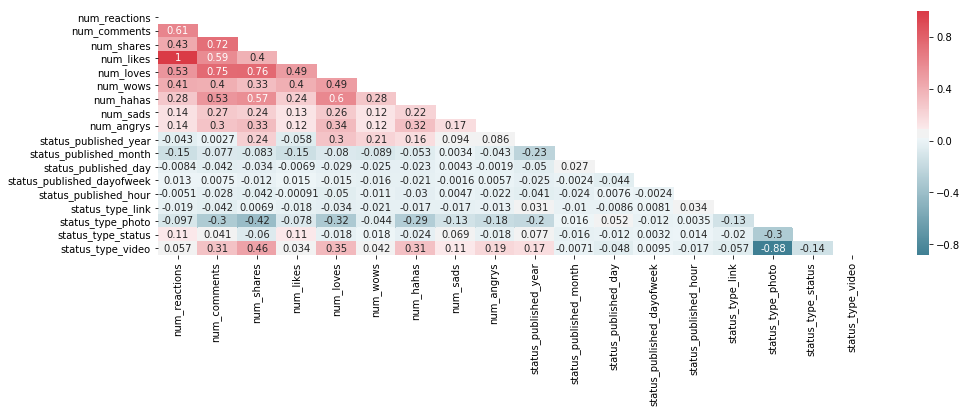

In [31]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(16, 4.5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True)

In [32]:
import math
from scipy.stats import pearsonr

corr = df.corr()
corr_abs = corr.abs()
corr_tuples = []

# get highest corr for each col
for (i, col) in enumerate(corr_abs.columns):
    corr_with_col = corr_abs.iloc[:, i]\
        .sort_values(ascending=False)
    
    highest_corr = corr_with_col[1]
    if not math.isnan(highest_corr):
        col2 = corr_with_col.index[1]
        pvalue = pearsonr(df[col], df[col2])[1]
        
        corr_tuples.append((col, col2, float(highest_corr), pvalue))    
        
# sort by corr
corr_tuples = sorted(corr_tuples, key=lambda x: x[2], reverse=True)

# remove duplicates
for i, tup in enumerate(corr_tuples):
    try:
        next_tup = corr_tuples[i + 1]    
        if next_tup[0] == tup[1] and next_tup[1] == tup[0]:
            corr_tuples.remove(tup)
    except IndexError:
        break

In [33]:
# P-value ≤ α: The correlation is statistically significant
# Usually, a significance level (denoted as α or alpha) of 0.05 works well
# https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/correlation/interpret-the-results/

for tup in corr_tuples:
    print(tup)

('num_likes', 'num_reactions', 0.9983547565835712, 0.0)
('status_type_video', 'status_type_photo', 0.882405213947888, 0.0)
('num_loves', 'num_shares', 0.7576280925884126, 0.0)
('num_comments', 'num_loves', 0.7545623353422239, 0.0)
('num_hahas', 'num_loves', 0.6012447807089705, 0.0)
('num_wows', 'num_loves', 0.48772917118876535, 0.0)
('num_angrys', 'num_loves', 0.3433426036538726, 2.4546792700549886e-161)
('status_type_status', 'status_type_photo', 0.3047974099327285, 7.308292643731947e-126)
('status_published_year', 'num_loves', 0.295485021949894, 4.673051383983342e-118)
('num_sads', 'num_comments', 0.26500840750383486, 1.7215296433455214e-94)
('status_published_month', 'status_published_year', 0.22851300405636193, 4.317346827329508e-70)
('status_type_link', 'status_type_photo', 0.12726866505213877, 1.5753613731294058e-22)
('status_published_day', 'status_type_photo', 0.05221053355212867, 6.52928406597269e-05)
('status_published_hour', 'num_loves', 0.050330457382888445, 0.0001186726378

In [34]:
# Scatter Plots for r > 0.7 and p < 0.05

sorted_pairs = list(filter(lambda x: x[2] > 0.7 and x[3] < 0.05, corr_tuples))
sorted_pairs

[('num_likes', 'num_reactions', 0.9983547565835712, 0.0),
 ('status_type_video', 'status_type_photo', 0.882405213947888, 0.0),
 ('num_loves', 'num_shares', 0.7576280925884126, 0.0),
 ('num_comments', 'num_loves', 0.7545623353422239, 0.0)]

In [35]:
# https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [36]:
import matplotlib.gridspec as gridspec

def plot_corr_pairs(sorted_pairs):
    ncols = min(len(sorted_pairs), 3)
    nrows = math.ceil(len(sorted_pairs) / ncols)
    
    fig = plt.figure(figsize=(13,8))
    gs = gridspec.GridSpec(nrows, ncols)       

    for i, sorted_pair in enumerate(sorted_pairs):        
        x = sorted_pair[0]
        y = sorted_pair[1]

        jp = sns.jointplot(x=x, y=y, data=df, kind='hex', gridsize=10)
        SeabornFig2Grid(jp, fig, gs[i])
        
    gs.tight_layout(fig)
    #gs.update(top=0.7)

    plt.show()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


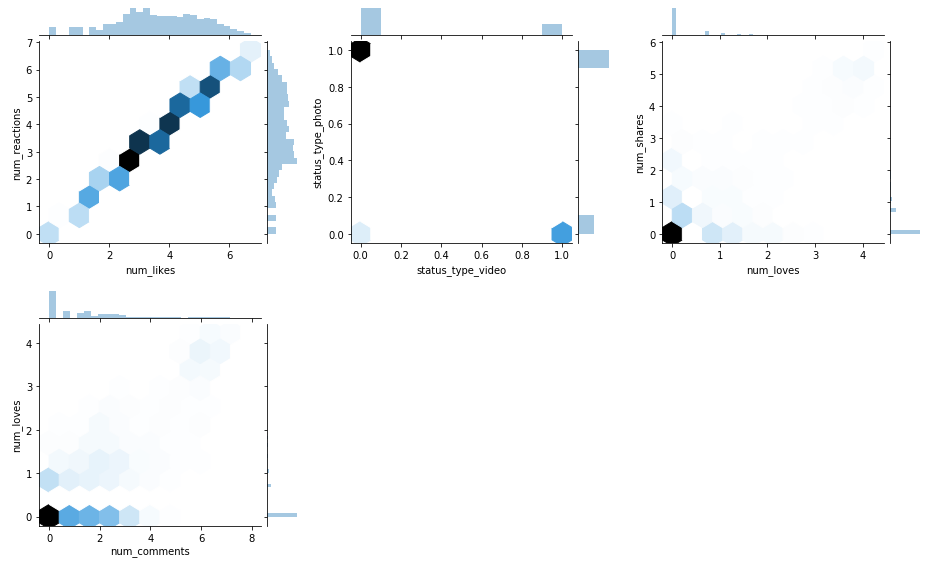

In [37]:
plot_corr_pairs(sorted_pairs)

# PCA

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

In [40]:
scaled_data.shape

(5843, 18)

In [41]:
x_pca.shape

(5843, 2)

In [42]:
# plt.figure(figsize=(8,6))
# plt.scatter(x_pca[:,0],x_pca[:,1])
# plt.xlabel('First principal component')
# plt.ylabel('Second Principal Component')

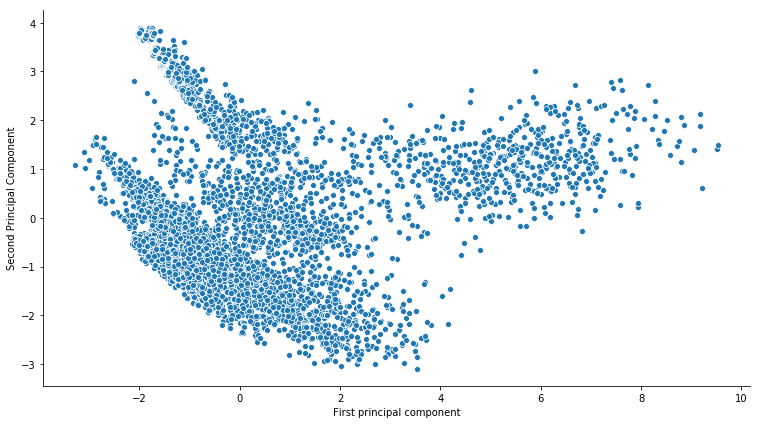

In [43]:
def plot_pca_results(hue=None):
    tmp_cols = ['First principal component', 'Second Principal Component']
    tmp_df = pd.DataFrame(data=x_pca, columns=tmp_cols)
    sns.relplot(x=tmp_cols[0], y=tmp_cols[1], data=tmp_df, hue=hue, height=6, aspect=8/4.5)
    
plot_pca_results()

In [44]:
pca.components_

array([[ 0.32280125,  0.3917833 ,  0.38415208,  0.30782519,  0.40382038,
         0.24521161,  0.30838595,  0.15439961,  0.19122131,  0.11114143,
        -0.07133315, -0.02381249, -0.00130834, -0.01945345, -0.00950004,
        -0.22587986,  0.02799961,  0.22580015],
       [-0.41205409, -0.09762799,  0.11614978, -0.42663038, -0.0024801 ,
        -0.20625373,  0.11517987,  0.04526146,  0.11620985,  0.22629055,
         0.06880948, -0.04967817, -0.00456357, -0.02277548,  0.05925163,
        -0.48709981, -0.0111166 ,  0.50394373]])

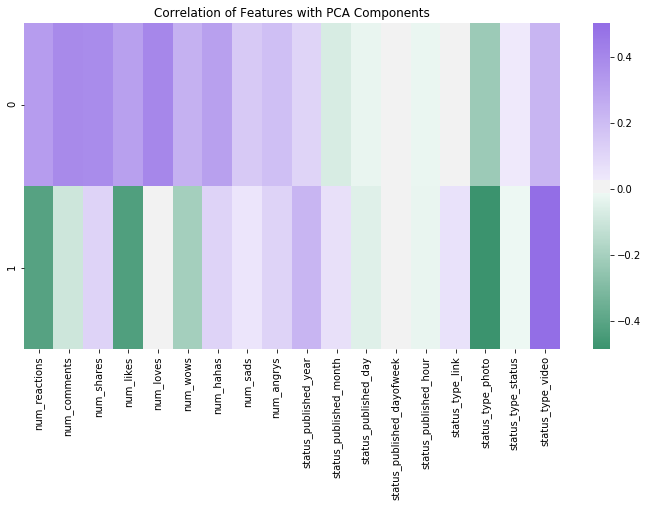

In [45]:
df_comp = pd.DataFrame(pca.components_, columns=df.columns)
plt.figure(figsize=(12,6))
plt.xlabel('Features')
plt.ylabel('PCA Components')
plt.title('Correlation of Features with PCA Components')
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)
sns.heatmap(df_comp, cmap=cmap)

# Different ML Clustering Models

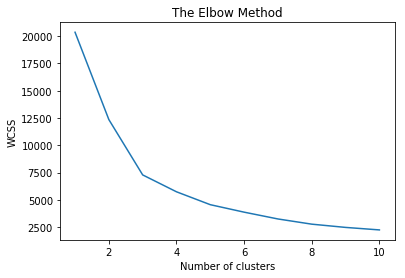

In [46]:
from sklearn.cluster import KMeans

wcss = []
models = []
for i in range(2, 12):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(x_pca)
    wcss.append(kmeans.inertia_)
    models.append(kmeans)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

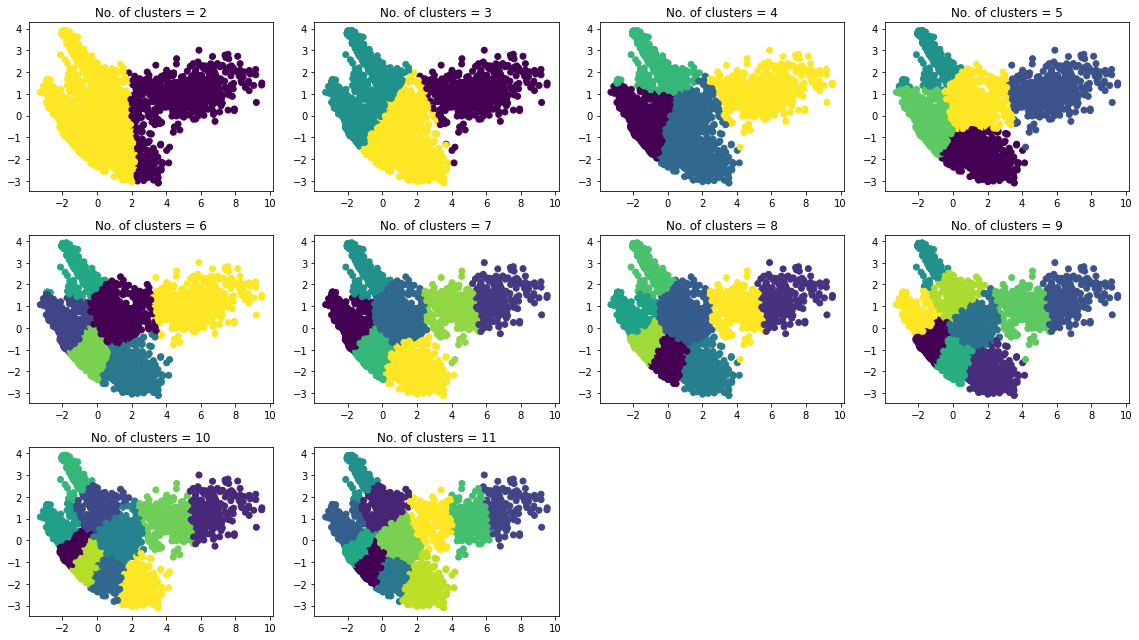

In [47]:
# raw_df -> remove outliers -> dropna -> log1p -> df -> pca -> kmeans

plt.figure(figsize=(16, 9))
for i, model in enumerate(models):
    preds = model.predict(x_pca)
    
    plt.subplot(3, 4, i + 1, title = 'No. of clusters = {}'.format(i + 2))
    plt.scatter(x_pca[:,0], x_pca[:,1], c=preds)

plt.tight_layout()

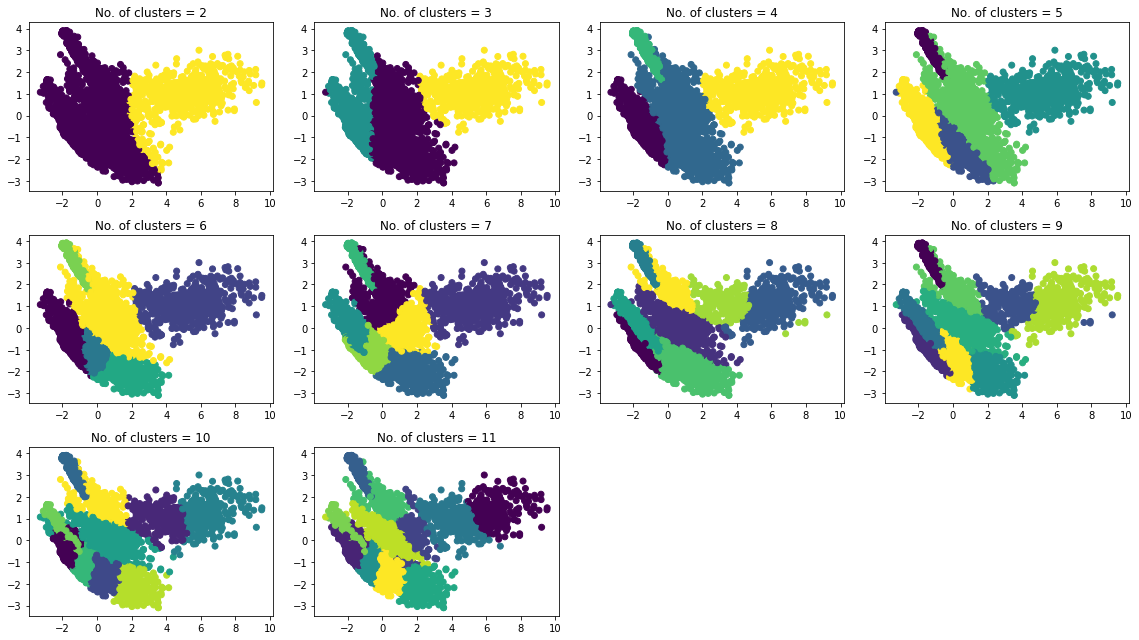

In [48]:
# https://www.datascience.com/blog/k-means-alternatives

from sklearn.mixture import GaussianMixture

plt.figure(figsize=(16, 9))
gm_models = []
for n_cluster in range(2, 12):
    gm_messy = GaussianMixture(n_components=n_cluster).fit(x_pca)
    gm_models.append(gm_messy)
    preds = gm_messy.predict(x_pca)
    
    plt.subplot(3, 4, n_cluster - 1, title = 'No. of clusters = {}'.format(n_cluster))
    plt.scatter(x_pca[:,0], x_pca[:,1], c=preds)

plt.tight_layout()

In [1]:
# import hdbscan

# clust_number = 2
# plot_number = 1
# plt.figure (figsize=(17,12))
# while clust_number < 21:
#     hdb = hdbscan.HDBSCAN(min_cluster_size=clust_number)
#     hdb_pred = hdb.fit(x_pca)
#     plt.subplot(5, 4, plot_number, title = 'Min. Cluster Size = {}'.format(clust_number))
#     plt.scatter(x_pca[:,0], x_pca[:,1], c=hdb_pred.labels_)
#     plot_number += 1
#     clust_number += 1

# plt.tight_layout()

In [55]:
def explore_each_cluster(model):
    preds = model.predict(x_pca)
    tmp_df = df.copy()
    tmp_df['cluster'] = preds
    return tmp_df

In [ ]:
# https://stackoverflow.com/questions/26762100/reconstruct-a-categorical-variable-from-dummies-in-pandas
def reverse_dummies(cat_df):
    x = cat_df.stack()
    return pd.Series(pd.Categorical(x[x!=0].index.get_level_values(1)))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


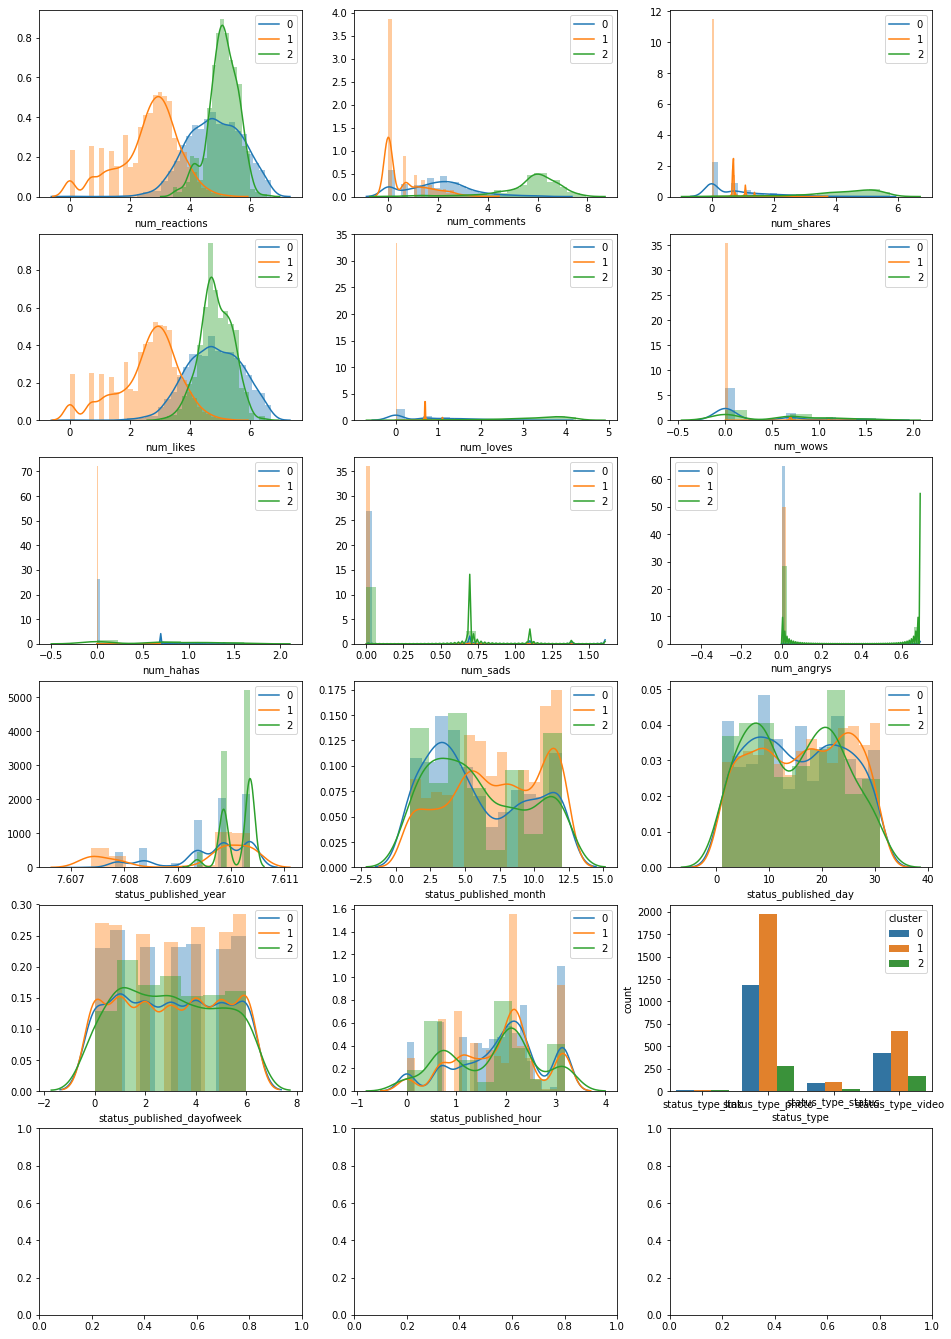

In [139]:
n_clusters = 3
df_cluster = explore_each_cluster(gm_models[n_clusters - 2])
cols = raw_df.columns
ncols = min(len(cols), 3)
nrows = math.ceil(len(cols) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(16, nrows * 4))


def get_ax(axes, feat_count):
    if ncols == 1 and nrows == 1:
        return axes
    elif ncols == 1 or nrows == 1:
        return axes[feat_count]
    else:
        return axes[int(feat_count / ncols), feat_count % ncols]


feat_count = 0

for i, col in enumerate(df_cluster.columns):
    if col not in numerical_cols:
        continue
    else:
        for cluster in range(0, n_clusters):
            sns.distplot(
                df_cluster[df_cluster['cluster'] == cluster][col], 
                ax=get_ax(axes, feat_count),
                kde_kws={"label": str(cluster)},
            )
        feat_count += 1

for col in cat_cols:
    separator = ''
    dummies_cols = [
        dcol for dcol in df_cluster.columns if dcol.startswith(col + separator)]
    tmp_series = reverse_dummies(df_cluster[dummies_cols])
    df_cluster[col] = tmp_series

    sns.countplot(x=col, data=df_cluster, hue='cluster',
                  ax=get_ax(axes, feat_count))
    feat_count += 1    